In [1]:
#Imports required for the code, imports were deleted for unused models
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #unused but kept in case its needed
import statsmodels.formula.api as smf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

file = "./GOT_character_predictions.xlsx"
got = pd.read_excel(io = file)
got.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   S.No                        1946 non-null   int64  
 1   name                        1946 non-null   object 
 2   title                       938 non-null    object 
 3   culture                     677 non-null    object 
 4   dateOfBirth                 433 non-null    float64
 5   mother                      21 non-null     object 
 6   father                      26 non-null     object 
 7   heir                        23 non-null     object 
 8   house                       1519 non-null   object 
 9   spouse                      276 non-null    object 
 10  book1_A_Game_Of_Thrones     1946 non-null   int64  
 11  book2_A_Clash_Of_Kings      1946 non-null   int64  
 12  book3_A_Storm_Of_Swords     1946 non-null   int64  
 13  book4_A_Feast_For_Crows     1946 

In [2]:
#Blank dataframe to create a record of missing values even if they are dropped from original dataframe
m_got = pd.DataFrame()
#Process to save reccord of missing values in both dataframes
for col in got:
    if got[col].isnull().astype(int).sum() > 0:
        got['m_'+col] = got[col].isnull().astype(int)
        m_got['m_'+col] = got[col].isnull().astype(int)

#To avoid overfitting im creating a sum of missing values            
got['m_count']=got['m_age']+got['m_isAliveSpouse']+got['m_isAliveHeir']+got['m_isAliveFather']+got['m_isAliveMother']+got['m_spouse']+got['m_heir']+got['m_father']+got['m_mother']+got['m_dateOfBirth']+got['m_culture']+got['m_title']

#Creating correlation to see which values are best for feature engineering
df_corr = got.corr(method = 'pearson').round(decimals = 2)
print(df_corr['isAlive'])
#Calculating percentage of missing values per column
print(((got.isnull().sum(axis = 0)/1946)*100).round(decimals = 2))

S.No                         -0.13
dateOfBirth                  -0.09
book1_A_Game_Of_Thrones      -0.15
book2_A_Clash_Of_Kings       -0.07
book3_A_Storm_Of_Swords       0.01
book4_A_Feast_For_Crows       0.27
book5_A_Dance_with_Dragons    0.03
isAliveMother                -0.04
isAliveFather                 0.20
isAliveHeir                   0.38
isAliveSpouse                 0.17
isMarried                    -0.05
isNoble                      -0.04
age                           0.09
numDeadRelations             -0.19
popularity                   -0.18
isAlive                       1.00
m_title                       0.04
m_culture                     0.04
m_dateOfBirth                 0.15
m_mother                      0.14
m_father                      0.14
m_heir                        0.13
m_house                       0.04
m_spouse                      0.05
m_isAliveMother               0.14
m_isAliveFather               0.14
m_isAliveHeir                 0.13
m_isAliveSpouse     

In [3]:
#Filling missing values (even if they are soon dropped)
NullPN = "Probably none"
got['title'] = got['title'].fillna(NullPN)
got['house'] = got['house'].fillna(NullPN)
got['age'] = got['age'].fillna(0)
got['dateOfBirth'] = got['dateOfBirth'].fillna(0)
got['isAliveMother'] = got['isAliveMother'].fillna(0)
got['isAliveFather'] = got['isAliveFather'].fillna(0)
got['isAliveHeir'] = got['isAliveHeir'].fillna(0)
got['isAliveSpouse'] = got['isAliveSpouse'].fillna(0)
got['culture'] = got['culture'].fillna("Unknown")

#Changing columns to int in order to make code easier
got['age'] = got['age'].astype(int)
got['dateOfBirth'] = got['dateOfBirth'].astype(int)
got['isAliveFather'] = got['isAliveFather'].astype(int)
got['isAliveHeir'] = got['isAliveHeir'].astype(int)
got['popularity'] = got['popularity'].astype(int)

#List of all cultures on the continent of Essos
lstEssosCultures=['Valyrian','Braavosi','Summer Isles','Dothraki','Ghiscari','Lhazarene','Qartheen','Lysene','Quarth','Lyseni','Qohor','Norvoshi','Meereenese','Astapori','Ghiscaricari','Braavos','Myrish','Lhazareen','Pentoshi','Summer Islander','Summer Islands','Asshai','Naathi','Rhoynar','Meereen','Norvos','Astapor',"""Asshai'i""",'Ibbenese']

#For-loop for feature engineering
for row, col in got.iterrows():
    #Feature to determine continent of origin for character
    if got.loc[row,'culture'] in lstEssosCultures:
        got.loc[row,'From_Essos'] = 1
    else:
        got.loc[row,'From_Essos'] = 0
    #Feature to estimate which characters are extras and require clarification
    if '(' in got.loc[row,'name']:
        got.loc[row,'()inName'] = 1
    else:
        got.loc[row,'()inName'] = 0
    #Most important feature, determines weather the date of birth and age match the current year
    if got.loc[row,'m_age']+got.loc[row,'m_dateOfBirth']>0:
        got.loc[row,'agecheck'] = "Unknown"
    elif got.loc[row,'age']+got.loc[row,'dateOfBirth']==305:
        got.loc[row,'agecheck'] = "Pass"
    elif got.loc[row,'age']+got.loc[row,'dateOfBirth']<305:
        got.loc[row,'agecheck'] = "Fail"
    else:
        print(f"""Problem with agecheck in row {row}""")
    #Feature for grouping order of appearance into 7 groups so the variable is usable    
    if got.loc[row,'S.No']<=278:
        got.loc[row,'order'] = 1
    elif got.loc[row,'S.No']<=556:
        got.loc[row,'order'] = 2
    elif got.loc[row,'S.No']<=834:
        got.loc[row,'order'] = 3
    elif got.loc[row,'S.No']<=1112:
        got.loc[row,'order'] = 4
    elif got.loc[row,'S.No']<=1390:
        got.loc[row,'order'] = 5
    elif got.loc[row,'S.No']<=1668:
        got.loc[row,'order'] = 6
    elif got.loc[row,'S.No']<=1946:
        got.loc[row,'order'] = 7
    else:
        print("Problem with S.No")
#I realy liked this feature but it had to be deleted due to little impact, 
#but decided to keep it as a string just in case   
deleted_features = """
pQ1 = np.quantile(got['popularity'],0.25)
pQ2 = np.quantile(got['popularity'],0.5)
pQ3 = np.quantile(got['popularity'],0.75)
pQ4 = np.quantile(got['popularity'],1)
print(pQ1,pQ2,pQ3,pQ4)
        
    if got.loc[row,'popularity']<=pQ1:
        got.loc[row, 'pop'] = 1
    elif got.loc[row,'popularity']<=pQ2:
        got.loc[row, 'pop'] = 2
    elif got.loc[row,'popularity']<=pQ3:
        got.loc[row, 'pop'] = 3
    elif got.loc[row,'popularity']<=pQ4:
        got.loc[row, 'pop'] = 4
    else:
        print("Error with popularity quartiles")"""    

#Dummy sorting for agecheck feature    
got = pd.get_dummies(columns = ['agecheck'], data = got)
#Droping most m_variables to avoid overfitting
got = got.drop(['m_title', 'm_culture', 'm_house', 'm_spouse','m_isAliveSpouse','m_isAliveHeir','m_dateOfBirth','m_isAliveFather','isAliveHeir','isAliveFather','m_heir'],axis = 1)
#Dropped these variables since the feature engineering process made them redundant
got = got.drop(['dateOfBirth','age','agecheck_Unknown','S.No'],axis=1)
#Columns dropped due to loy correl or feature importance
got = got.drop(['isNoble','name','mother','father','heir','spouse','isAliveMother','isMarried','isAliveSpouse'],axis = 1)
got = got.drop(['book2_A_Clash_Of_Kings','book3_A_Storm_Of_Swords','book5_A_Dance_with_Dragons'],axis = 1)
#Dropped for not being usable due to dType, m_values and low quantity
got = got.drop(['title','culture','house'],axis=1)
#I originaly deleted S.No here since but after learning its the order of appearance in the books I decided to keep it


In [4]:
#Checking the new features from past cell
df_corr = got.corr(method = 'pearson').round(decimals = 2)
print(df_corr['isAlive'])
got.info()

book1_A_Game_Of_Thrones   -0.15
book4_A_Feast_For_Crows    0.27
numDeadRelations          -0.19
popularity                -0.02
isAlive                    1.00
m_mother                   0.14
m_father                   0.14
m_isAliveMother            0.14
m_age                      0.15
m_count                    0.19
From_Essos                -0.07
()inName                  -0.02
order                     -0.13
agecheck_Fail             -0.52
agecheck_Pass              0.23
Name: isAlive, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   book1_A_Game_Of_Thrones  1946 non-null   int64  
 1   book4_A_Feast_For_Crows  1946 non-null   int64  
 2   numDeadRelations         1946 non-null   int64  
 3   popularity               1946 non-null   int64  
 4   isAlive                  1946 non-null   int64  
 5   

In [5]:
#Separating X and Y variables
gotx =  got.drop(['isAlive'],axis=1)
goty =  got.loc[ : , 'isAlive']

#Creating the train/test split
x_train, x_test, y_train, y_test = train_test_split(
            gotx,
            goty,
            random_state = 219,
            test_size    = 0.1,
            stratify     = goty)

In [6]:
GBM = GradientBoostingClassifier(loss = 'exponential',
                                 learning_rate = 0.1,
                                 n_estimators = 100,
                                 criterion = 'friedman_mse',
                                 max_depth = 7,
                                 warm_start = False,
                                 max_features = 'sqrt',
                                 random_state  = 219)
                                 #Hyperparameters from cv already added

GBM_fit = GBM.fit(x_train, y_train)
GBM_pred = GBM.predict(x_test)

gbm_tn, gbm_fp, gbm_fn, gbm_tp = confusion_matrix(y_true = y_test, y_pred = GBM_pred).ravel()

#Creating variable for GBM results
GBM_results = (f"""Gradient Boosted Model results:

(Final model!)

Training ACCURACY : {(GBM_fit.score(x_train, y_train)*100).round(2)}%
Testing ACCURACY  : {(GBM_fit.score(x_test, y_test)*100).round(2)}%
Gap (abs)         : {((abs(GBM_fit.score(x_train, y_train)-GBM_fit.score(x_test, y_test)))*100).round(2)}%

AUC Score         : {(roc_auc_score(y_true  = y_test,
                                  y_score = GBM_pred)*100).round(2)}%
                                  
True Positives    : {gbm_tp}
False Positives   : {gbm_fp}
False Negatives   : {gbm_fn}
True Negatives    : {gbm_tn}

Precision         : {((gbm_tp/(gbm_tp+gbm_fp))*100).round(2)}%
Sensitivity       : {((gbm_tp/(gbm_tp+gbm_fn))*100).round(2)}%
Specificity       : {((gbm_tn/(gbm_tn+gbm_fp))*100).round(2)}%
Accuracy          : {(((gbm_tp+gbm_tn)/(gbm_tp+gbm_tn+gbm_fp+gbm_fn))*100).round(2)}%
""")
#Many values were changed to percentages and rounded to 2 decimals so all the data would match
#as LRM's auc score only had 2 decimal places
print(GBM_results)

Gradient Boosted Model results:

(Final model!)

Training ACCURACY : 86.41%
Testing ACCURACY  : 89.74%
Gap (abs)         : 3.34%

AUC Score         : 84.59%
                                  
True Positives    : 138
False Positives   : 13
False Negatives   : 7
True Negatives    : 37

Precision         : 91.39%
Sensitivity       : 95.17%
Specificity       : 74.0%
Accuracy          : 89.74%



In [7]:
#Formula for determining best parameters for GBM
cvGBM = """
l_rate = np.arange(0.1, 1.01, 0.1)
lossP = ['deviance', 'exponential']
estimators = np.arange(100, 501, 50)
m_depth = np.arange(2, 8.1, 1)
warm_start_range = [False]
crit = ['friedman_mse']
max_f = ['auto', 'sqrt','log2']
#used help(GradientBoostingClassifier) to determine the best parameters to check

param_grid = {'learning_rate': l_rate,
              'max_depth': m_depth,
              'n_estimators': estimators,
              'warm_start': warm_start_range,
              'criterion': crit,
              'loss': lossP,
              'max_features': max_f}

fGBM = GradientBoostingClassifier(random_state = 219)

fGBM_cv = RandomizedSearchCV(estimator = fGBM,
                           param_distributions = param_grid,
                           cv = 2,
                           n_iter = 1500,
                           random_state = 219,
                           scoring = make_scorer(roc_auc_score,
                                     needs_threshold = False))

fGBM_cv.fit(gotx, goty)

print("Best Parameters : ", fGBM_cv.best_params_)
print("Best AUC : ", fGBM_cv.best_score_.round(4))"""
#This is converted into string in order to cut proccessing time

In [8]:
#Finction to create feature importance graph for model
def plot_feature_importances(model, train):
    """model : What type of model is being tested
    train : Training data used in model"""
    n_features = train.shape[1]
    
    fig, ax = plt.subplots(figsize=(10,10))
    
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

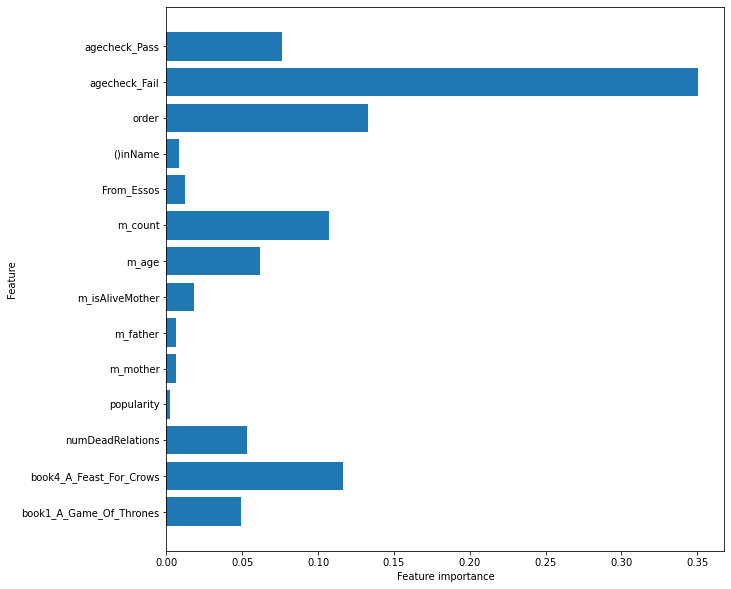

In [9]:
#Determining best features in GBM model, a lot of variables were dropped above due to this proccess
plot_feature_importances(GBM_fit,x_train)

In [10]:
LRM = LogisticRegression(solver = 'sag',
                                C = 4.9,
                                warm_start = True,
                                random_state = 219,
                                max_iter = 1000)
                                #Hyperparameters from cv already added
    
LRM_fit = LRM.fit(x_train, y_train)
LRM_pred = LRM_fit.predict(x_test)

lrm_tn, lrm_fp, lrm_fn, lrm_tp = confusion_matrix(y_true = y_test, y_pred = LRM_pred).ravel()

#Creating results string
LRM_results = (f"""Lineal Regression Model results:

(Not the final model!)

Training ACCURACY : {(LRM_fit.score(x_train, y_train)*100).round(2)}%
Testing ACCURACY  : {(LRM_fit.score(x_test, y_test)*100).round(2)}%
Gap (abs)         : {(abs(LRM_fit.score(x_train, y_train)-LRM_fit.score(x_test, y_test))*100).round(2)}%

AUC Score         : {(roc_auc_score(y_true  = y_test,
                                  y_score = LRM_pred)*100).round(2)}%
                                  
True Positives    : {lrm_tp}
False Positives   : {lrm_fp}
False Negatives   : {lrm_fn}
True Negatives    : {lrm_tn}

Precision         : {((lrm_tp/(lrm_tp+lrm_fp))*100).round(2)}%
Sensitivity       : {((lrm_tp/(lrm_tp+lrm_fn))*100).round(2)}%
Specificity       : {((lrm_tn/(lrm_tn+lrm_fp))*100).round(2)}%
Accuracy          : {(((lrm_tp+lrm_tn)/(lrm_tp+lrm_tn+lrm_fp+lrm_fn))*100).round(2)}%
""")
print(LRM_results)
#Even though this model had the best AUC score, the train-test gap indicated overfitting

Lineal Regression Model results:

(Not the final model!)

Training ACCURACY : 84.07%
Testing ACCURACY  : 92.82%
Gap (abs)         : 8.75%

AUC Score         : 86.0%
                                  
True Positives    : 145
False Positives   : 14
False Negatives   : 0
True Negatives    : 36

Precision         : 91.19%
Sensitivity       : 100.0%
Specificity       : 72.0%
Accuracy          : 92.82%



In [11]:
#Formula for determining best parameters for LRM
cvLRM = """
C_range = np.arange(0.1, 5.1, 0.1)
warm_start_range = [True, False]
solver_range = ['newton-cg', 'sag', 'lbfgs']
cw = ['None','balanced']

param_gridl = {'C': C_range,
              'warm_start': warm_start_range,
              'solver': solver_range,
              'class_weight': cw}

fLRH = LogisticRegression(random_state = 219,
                              max_iter     = 1000) 

fLRH_cv = RandomizedSearchCV(estimator = fLRH,
                             param_distributions = param_gridl,
                             cv = 3,
                             n_iter = 250,
                             random_state = 219,
                             scoring = make_scorer(roc_auc_score,
                                       needs_threshold = False))

fLRH_cv.fit(gotx, goty)

print("Best Parameters:",fLRH_cv.best_params_)
print("Best AUC:",fLRH_cv.best_score_.round(4))
print("Best Estimator:",fLRH_cv.best_estimator_)"""
#This is converted into string in order to cut proccessing time

In [12]:
#Models such as random forest and KNN were removed as they didnt provide
#significant changes to the code.
print(f"""
Top 2 models: GBM and LRM (both tuned)
Due to overfitting on LRM, GBM was deemed the best final model.
-----------------------------------

{GBM_results}
-----------------------------------

{LRM_results}
-----------------------------------""")


Top 2 models: GBM and LRM (both tuned)
Due to overfitting on LRM, GBM was deemed the best final model.
-----------------------------------

Gradient Boosted Model results:

(Final model!)

Training ACCURACY : 86.41%
Testing ACCURACY  : 89.74%
Gap (abs)         : 3.34%

AUC Score         : 84.59%
                                  
True Positives    : 138
False Positives   : 13
False Negatives   : 7
True Negatives    : 37

Precision         : 91.39%
Sensitivity       : 95.17%
Specificity       : 74.0%
Accuracy          : 89.74%

-----------------------------------

Lineal Regression Model results:

(Not the final model!)

Training ACCURACY : 84.07%
Testing ACCURACY  : 92.82%
Gap (abs)         : 8.75%

AUC Score         : 86.0%
                                  
True Positives    : 145
False Positives   : 14
False Negatives   : 0
True Negatives    : 36

Precision         : 91.19%
Sensitivity       : 100.0%
Specificity       : 72.0%
Accuracy          : 92.82%

----------------------------